# **Music recommender**

#### **Setup**

In [2]:
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

#### **Load & preprocess**

In [3]:
df_raw = pd.read_csv("dataset.csv") # source: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data

pd.set_option('display.max_columns', None)
df_raw.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
print("Loaded shape: ", df_raw.shape)
print("\nData types: \n", df_raw.dtypes)

Loaded shape:  (114000, 21)

Data types: 
 Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


#### **Checking missing values**

In [5]:
print(df_raw.isna().sum())

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [6]:
df_raw = df_raw.dropna()

In [7]:
for col in ["artists", "album_name", "track_name", "track_genre", "explicit"]:
    print(f"{col}: {df_raw[col].nunique()} unique")

artists: 31437 unique
album_name: 46589 unique
track_name: 73608 unique
track_genre: 114 unique
explicit: 2 unique


In [8]:
id_cols = ["track_id", "artists", "album_name", "track_name", "track_genre", 
           "popularity", "duration_ms", "explicit"]

num_cols = [
    "danceability","energy","key","loudness","mode","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"]

keep_cols = id_cols + [c for c in num_cols]

df = df_raw[keep_cols].copy()

In [9]:
before = df.shape[0]
df = df.drop_duplicates(subset=["track_id"])
after = df.shape[0]
print(f"Deduplicated track_id: {before} -> {after}")

Deduplicated track_id: 113999 -> 89740


In [10]:
before_artist_title = df.shape[0]
df = df.drop_duplicates(subset=["artists", "track_name"])
after_artist_title = df.shape[0]
print(f"Deduplicated by artists and track_name: {before_artist_title} -> {after_artist_title}")

Deduplicated by artists and track_name: 89740 -> 81343


In [11]:
df = df.reset_index(drop=True)
info_cols = [c for c in ["track_id", "track_name", "artists", "album_name", "track_genre", "popularity", "duration_ms", "explicit"]]
info = df[info_cols].copy()

#### **Mapping detailed genres to broader categories**

In [12]:
genre_map = {
    'acoustic': 'acoustic/folk', 'folk': 'acoustic/folk', 'bluegrass': 'acoustic/folk', 'singer-songwriter': 'acoustic/folk', 'guitar': 'acoustic/folk',
    'alt-rock': 'rock', 'alternative': 'rock', 'british': 'rock', 'emo': 'rock', 'grunge': 'rock', 'hard-rock': 'rock', 'indie': 'rock', 'indie-pop': 'rock',
    'punk': 'rock', 'punk-rock': 'rock', 'psych-rock': 'rock', 'rock': 'rock', 'rock-n-roll': 'rock', 'rockabilly': 'rock', 'ska': 'rock', 'goth': 'rock', 'garage': 'rock',
    'metal': 'metal', 'heavy-metal': 'metal', 'black-metal': 'metal', 'death-metal': 'metal', 'grindcore': 'metal', 'metalcore': 'metal',
    'pop': 'pop', 'power-pop': 'pop', 'synth-pop': 'pop', 'dance-pop': 'pop', 'pop-film': 'pop', 'romance': 'pop', 'sad': 'pop',
    'r-n-b': 'rnb/soul/funk', 'soul': 'rnb/soul/funk', 'funk': 'rnb/soul/funk', 'gospel': 'rnb/soul/funk',
    'hip-hop': 'hip-hop',
    'edm': 'electronic/dance', 'electronic': 'electronic/dance', 'electro': 'electronic/dance', 'dance': 'electronic/dance', 'club': 'electronic/dance',
    'house': 'electronic/dance', 'deep-house': 'electronic/dance', 'progressive-house': 'electronic/dance', 'detroit-techno': 'electronic/dance',
    'techno': 'electronic/dance', 'minimal-techno': 'electronic/dance', 'trance': 'electronic/dance', 'ambient': 'electronic/dance', 'idm': 'electronic/dance',
    'dubstep': 'electronic/dance', 'drum-and-bass': 'electronic/dance', 'dub': 'electronic/dance', 'breakbeat': 'electronic/dance', 'industrial': 'electronic/dance',
    'dancehall': 'electronic/dance',
    'latin': 'latin/world', 'latino': 'latin/world', 'brazil': 'latin/world', 'mpb': 'latin/world', 'samba': 'latin/world', 'pagode': 'latin/world', 'forro': 'latin/world',
    'salsa': 'latin/world', 'tango': 'latin/world', 'sertanejo': 'latin/world', 'world-music': 'latin/world', 'turkish': 'latin/world', 'indian': 'latin/world',
    'iranian': 'latin/world', 'malay': 'latin/world', 'swedish': 'latin/world', 'spanish': 'latin/world', 'french': 'latin/world', 'german': 'latin/world',
    'j-pop': 'asian', 'j-rock': 'asian', 'j-dance': 'asian', 'j-idol': 'asian', 'anime': 'asian', 'cantopop': 'asian', 'mandopop': 'asian', 'k-pop': 'asian',
    'jazz': 'jazz/classical', 'classical': 'jazz/classical', 'opera': 'jazz/classical', 'piano': 'jazz/classical',
    'study': 'functional', 'sleep': 'functional', 'kids': 'functional', 'children': 'functional',
    'disney': 'functional', 'comedy': 'functional', 'show-tunes': 'functional', 'party': 'functional', 'happy': 'functional',
}

df['broad_genre'] = df['track_genre'].str.lower().map(genre_map).fillna('other')
print(df['broad_genre'].value_counts())

broad_genre
latin/world         14900
electronic/dance    14239
rock                 9991
other                9921
functional           8169
asian                6288
metal                4707
pop                  4040
acoustic/folk        3964
jazz/classical       2473
rnb/soul/funk        1992
hip-hop               659
Name: count, dtype: int64


#### **Numerical features scaling**

In [13]:
num_cols = [c for c in num_cols if c != 'time_signature']
X_num = df[num_cols].astype(float).copy()

scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(X_num)
print("Numeric feature matrix shape:", X_num_scaled.shape)

Numeric feature matrix shape: (81343, 11)


#### **One-hot encoding**

In [14]:
genre_dummies = pd.get_dummies(df['broad_genre'], prefix='genre')
print("One-hot genre columns:", genre_dummies.columns.tolist())

genre_weight = 0.1
genre_matrix = genre_dummies.values * genre_weight

One-hot genre columns: ['genre_acoustic/folk', 'genre_asian', 'genre_electronic/dance', 'genre_functional', 'genre_hip-hop', 'genre_jazz/classical', 'genre_latin/world', 'genre_metal', 'genre_other', 'genre_pop', 'genre_rnb/soul/funk', 'genre_rock']


In [15]:
X_combined = np.hstack([X_num_scaled, genre_matrix])
print("Combined feature matrix shape (num + genres):", X_combined.shape)

Combined feature matrix shape (num + genres): (81343, 23)


In [16]:
X_final = normalize(X_combined, norm='l2', axis=1)
combined_feature_names = list(num_cols) + list(genre_dummies.columns)
X_final_df = pd.DataFrame(X_final, columns=[f"f_{i}" for i in range(X_final.shape[1])], index=df.index)


#### **Exploratory visualizations**

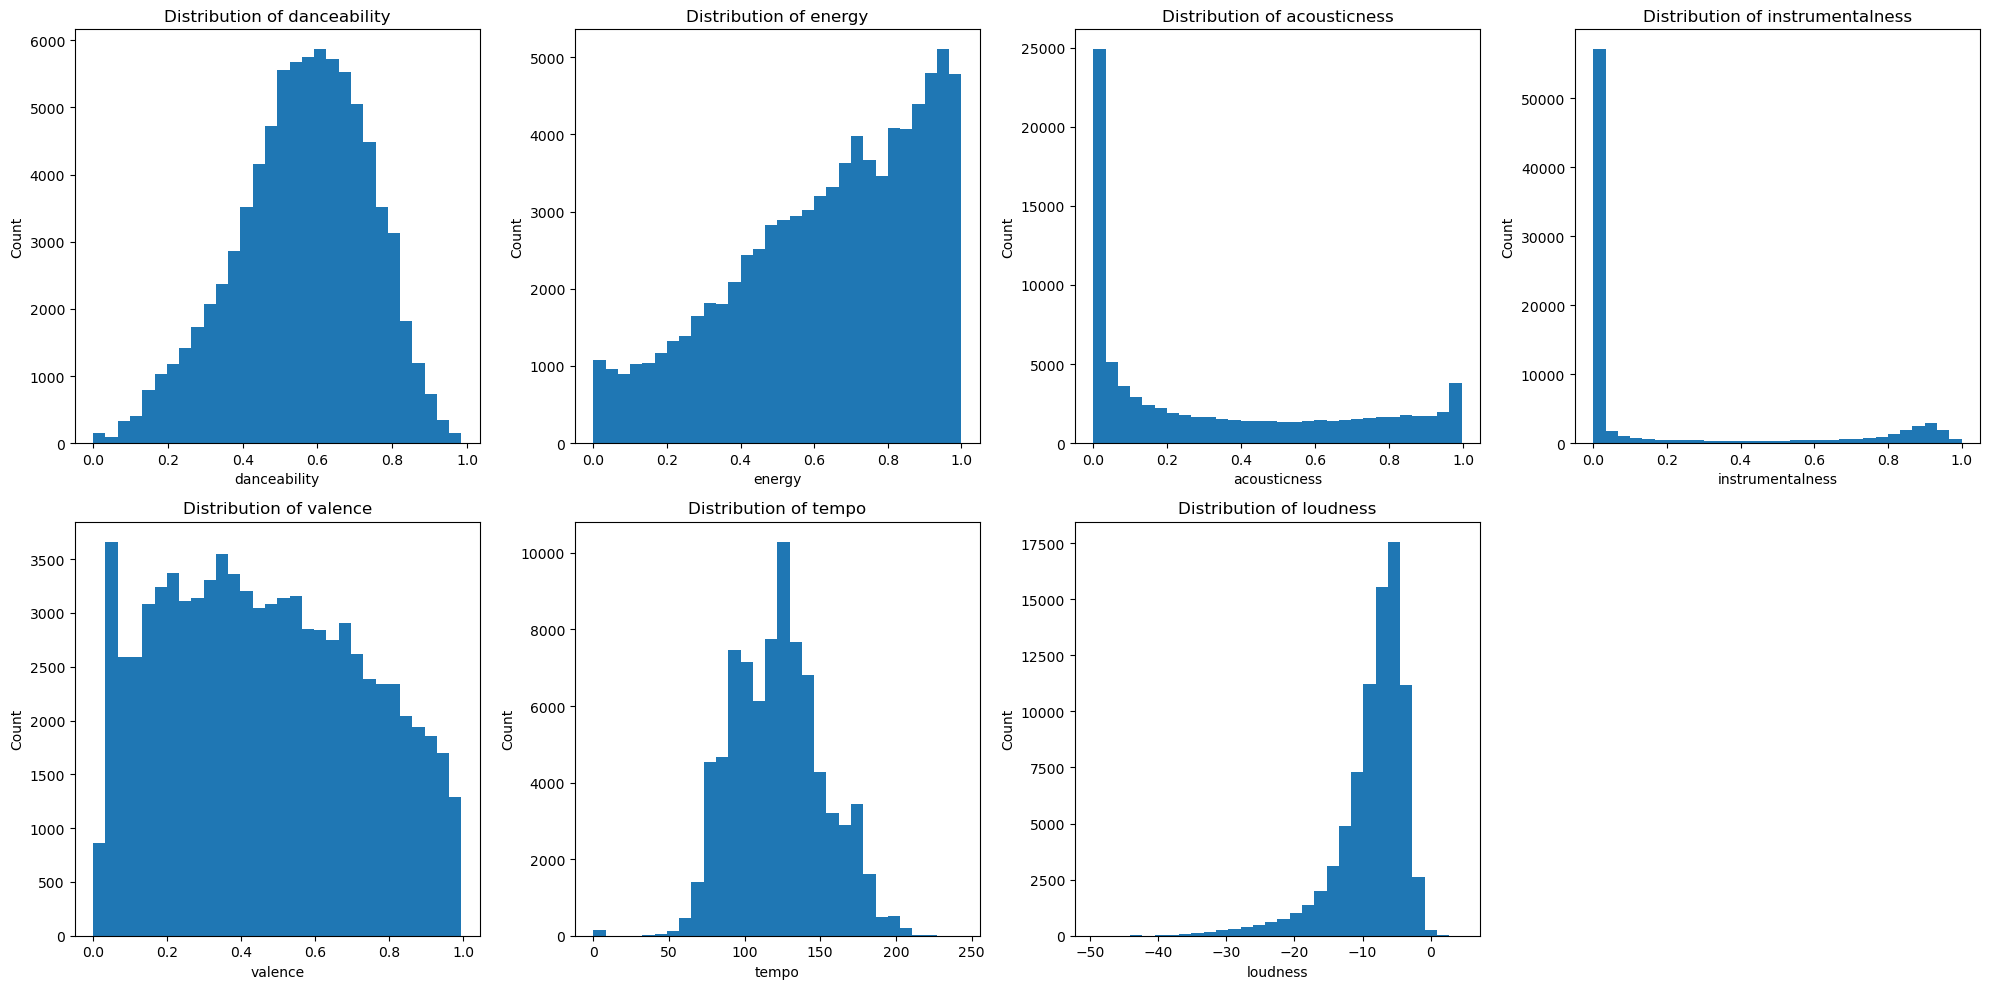

In [17]:
cols = ["danceability", "energy", "acousticness", "instrumentalness", "valence", "tempo", "loudness"]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].hist(df[col].dropna(), bins=30)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


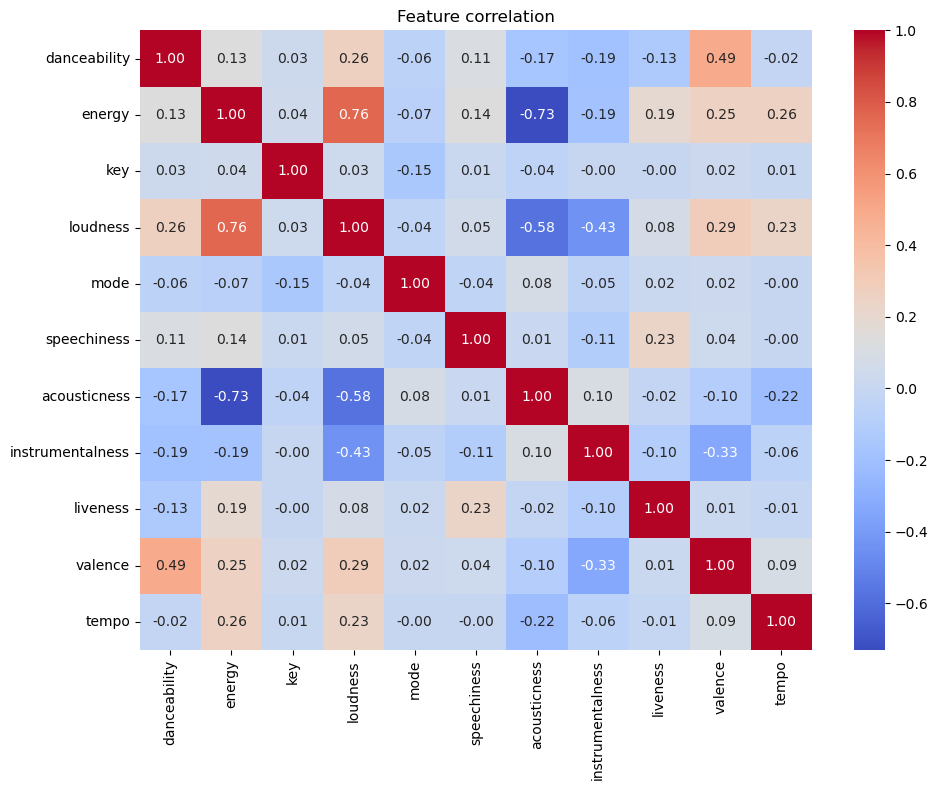

In [18]:
corr = pd.DataFrame(X_num_scaled, columns=num_cols).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=num_cols, yticklabels=num_cols)
plt.title("Feature correlation")
plt.tight_layout()
plt.show()


#### **Cosine similary recommender**

In [19]:
def recommend_cosine(track_idx, X_final, info, n_recs=10):
    sims = cosine_similarity([X_final[track_idx]], X_final)[0]
    rec_idx = np.argsort(-sims)[1:n_recs+1]
    recs = info.iloc[rec_idx].copy()
    recs['similarity'] = sims[rec_idx]

    base_song = info.iloc[[track_idx]].copy()
    base_song['similarity'] = 1.0

    result = pd.concat([base_song, recs]).reset_index(drop=True)
    return result.sort_values('similarity', ascending=False)

recs_with_base = recommend_cosine(0, X_final, info, n_recs=5)
display(recs_with_base[['track_name','artists','track_genre','similarity']])


,track_name,artists,track_genre,similarity
0,Comedy,Gen Hoshino,acoustic,1.000000
1,Baari Barsi,Salim–Sulaiman;Harshdeep Kaur;Labh Janjua;Amit...,folk,0.990921
2,JAMAICA,Feid;Sech,pop,0.987615
3,En El Coche,Aitana,spanish,0.987383
4,Agosto,Bad Bunny,latino,0.986045
5,Trouble’s Coming,Royal Blood,garage,0.985007


#### **k-Nearest Neighbors recommender**

In [20]:
knn_model = NearestNeighbors(n_neighbors=11, metric='cosine')
knn_model.fit(X_final)

def knn_recommender(track_idx, knn_model, X_final, info, n_recs=10):
    distances, indices = knn_model.kneighbors([X_final[track_idx]], n_neighbors=n_recs + 1)
    rec_indices = indices[0][1:]
    rec_distances = distances[0][1:]
    
    recs = info.iloc[rec_indices].copy()
    recs['distance'] = rec_distances
    recs['similarity'] = 1 - recs['distance']
    
    base_song = info.iloc[[track_idx]].copy()
    base_song['distance'] = 0.0
    base_song['similarity'] = 1.0
    
    result = pd.concat([base_song, recs]).reset_index(drop=True)
    return result.sort_values('similarity', ascending=False)

knn_recs_with_base = knn_recommender(track_idx=17177, knn_model=knn_model, X_final=X_final, info=info, n_recs=5)
display(knn_recs_with_base[['track_name','artists','track_genre','similarity']])


,track_name,artists,track_genre,similarity
0,The Nights,Avicii,dance,1.000000
1,Megaman,Psychostick,industrial,0.997394
2,Metaldonna Medley,Psychostick,industrial,0.997301
3,Don't Stop,Glee Cast,club,0.997011
4,Double Edge (feat. Sway and P Money),Flux Pavilion;Sway and P Money,dub,0.996951
5,Something Beautiful,Armin van Buuren,progressive-house,0.996867


#### **KMeans recommender**

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_final)
print("PCA-transformed feature matrix shape:", X_pca.shape)

PCA-transformed feature matrix shape: (81343, 10)


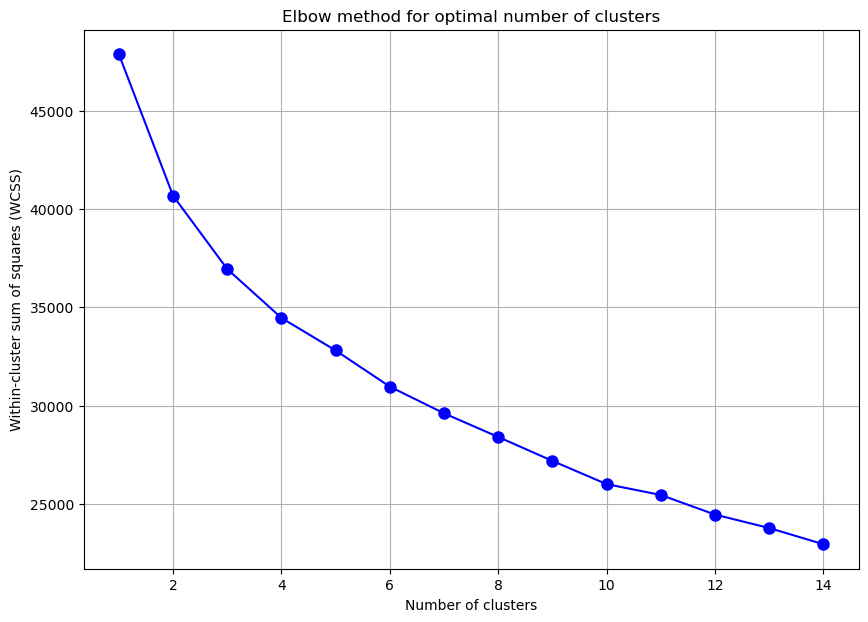

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_final)

k_values = range(1, 15)

wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 7))
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()

Silhouette score for k=2: 0.1718


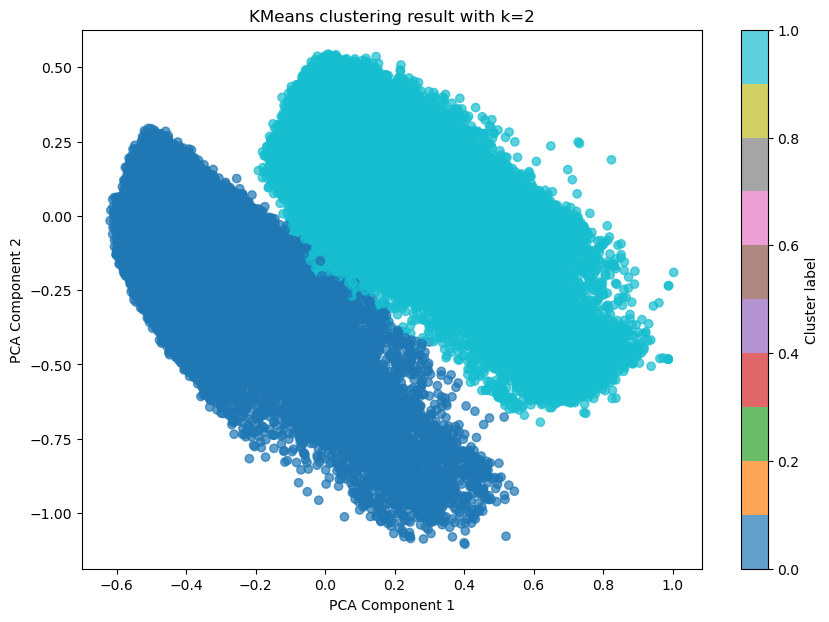

In [ ]:
final_k = 4
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

if len(set(cluster_labels)) > 1:
    s_score = silhouette_score(X_scaled, cluster_labels)
else:
    s_score = 0

print(f"Silhouette score for k={final_k}: {s_score:.4f}")

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'KMeans clustering result with k={final_k}')
plt.colorbar(scatter, label='Cluster label')
plt.show()

In [ ]:
def recommend_kmeans(track_idx, X_final, info, n_recs=10, n_clusters=2, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_final)
    
    track_cluster = cluster_labels[track_idx]
    same_cluster_idx = np.where(cluster_labels == track_cluster)[0]
    same_cluster_idx = same_cluster_idx[same_cluster_idx != track_idx]
    
    sims = cosine_similarity([X_final[track_idx]], X_final[same_cluster_idx])[0]
    top_idx = np.argsort(-sims)[:n_recs]
    rec_indices = same_cluster_idx[top_idx]
    
    recs = info.iloc[rec_indices].copy()
    recs['similarity'] = sims[top_idx]
    
    base_song = info.iloc[[track_idx]].copy()
    base_song['similarity'] = 1.0
    
    result = pd.concat([base_song, recs]).reset_index(drop=True)
    return result.sort_values('similarity', ascending=False)

recs_kmeans_with_base = recommend_kmeans(track_idx=65870, X_final=X_final, info=info, n_recs=5, n_clusters=final_k)
display(recs_kmeans_with_base[['track_name', 'artists', 'track_genre', 'similarity']])


,track_name,artists,track_genre,similarity
0,Radioactive,Imagine Dragons,rock,1.000000
1,Numb,Linkin Park,alternative,0.996028
2,Check My Brain,Alice In Chains,grunge,0.995435
3,Poder Pra Salvar,Hillsong Em Português,gospel,0.994951
4,Olvidar/El Oasis/Saber Perder - En Vivo,Los Caligaris,ska,0.994713
5,Year Zero,Ghost,hard-rock,0.994496
